In [1]:
import findspark
findspark.init()

In [2]:
import pandas_gbq
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Movie Recommendation System using Spark MLlib").getOrCreate()

In [3]:
import os
import sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [4]:
spark

In [5]:
ratings = spark.read.csv('ratings.csv', header=True)

In [6]:
ratings.printSchema()

root
 |-- userId: string (nullable = true)
 |-- movieId: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- timestamp: string (nullable = true)



In [7]:
ratings.count()

100836

In [8]:
ratings.describe()

DataFrame[summary: string, userId: string, movieId: string, rating: string, timestamp: string]

In [9]:
ratings = ratings.withColumn("userId", ratings["userId"].cast("int"))
ratings = ratings.withColumn("movieId", ratings["movieId"].cast("int"))
ratings = ratings.withColumn("rating", ratings["rating"].cast("float"))

In [10]:
ratings.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: float (nullable = true)
 |-- timestamp: string (nullable = true)



In [11]:
ratings.show(5, truncate = False)

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|1     |1      |4.0   |964982703|
|1     |3      |4.0   |964981247|
|1     |6      |4.0   |964982224|
|1     |47     |5.0   |964983815|
|1     |50     |5.0   |964982931|
+------+-------+------+---------+
only showing top 5 rows



In [12]:
ratings = ratings.drop('timestamp')

In [13]:
movies = spark.read.csv('movies.csv', header=True)

In [14]:
movies.printSchema()

root
 |-- movieId: string (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)



In [15]:
movies.describe()

DataFrame[summary: string, movieId: string, title: string, genres: string]

In [16]:
movies.show(5, truncate = False)

+-------+----------------------------------+-------------------------------------------+
|movieId|title                             |genres                                     |
+-------+----------------------------------+-------------------------------------------+
|1      |Toy Story (1995)                  |Adventure|Animation|Children|Comedy|Fantasy|
|2      |Jumanji (1995)                    |Adventure|Children|Fantasy                 |
|3      |Grumpier Old Men (1995)           |Comedy|Romance                             |
|4      |Waiting to Exhale (1995)          |Comedy|Drama|Romance                       |
|5      |Father of the Bride Part II (1995)|Comedy                                     |
+-------+----------------------------------+-------------------------------------------+
only showing top 5 rows



In [17]:
movies.select("movieId").distinct().count()

9742

In [18]:
links = spark.read.csv('links.csv', header=True)

In [19]:
links.printSchema()

root
 |-- movieId: string (nullable = true)
 |-- imdbId: string (nullable = true)
 |-- tmdbId: string (nullable = true)



In [20]:
links.describe()

DataFrame[summary: string, movieId: string, imdbId: string, tmdbId: string]

In [21]:
links.show(5)

+-------+-------+------+
|movieId| imdbId|tmdbId|
+-------+-------+------+
|      1|0114709|   862|
|      2|0113497|  8844|
|      3|0113228| 15602|
|      4|0114885| 31357|
|      5|0113041| 11862|
+-------+-------+------+
only showing top 5 rows



In [22]:
ratings.select('userID').distinct().count()

610

In [23]:
ratings.select("movieId").distinct().count()

9724

### Creating tables/views from the Spark Dataframe

In [24]:
# Creating dataframe as a table to perform query operations
ratings.createOrReplaceTempView("ratings_table")
movies.createOrReplaceTempView("movies_table")

In [25]:
all_movies = spark.sql('''SELECT * FROM movies_table limit 2''')

In [26]:
all_movies.toPandas()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy


In [27]:
all_ratings = spark.sql('''SELECT * FROM ratings_table ''')

In [28]:
all_ratings.show(5)

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|     1|      1|   4.0|
|     1|      3|   4.0|
|     1|      6|   4.0|
|     1|     47|   5.0|
|     1|     50|   5.0|
+------+-------+------+
only showing top 5 rows



In [29]:
# Query the movies which are not rated, movieIds that are in the movies table but not in the ratings table
non_rated_movies = spark.sql('''SELECT DISTINCT movieId FROM movies_table WHERE movieId NOT IN (SELECT DISTINCT movieId FROM ratings_table)''')

In [30]:
non_rated_movies.count()

18

In [31]:
non_rated_movies.toPandas().values

array([['5721'],
       ['26085'],
       ['1076'],
       ['3338'],
       ['8765'],
       ['6668'],
       ['7020'],
       ['32160'],
       ['3456'],
       ['4194'],
       ['30892'],
       ['2939'],
       ['7792'],
       ['34482'],
       ['32371'],
       ['6849'],
       ['25855'],
       ['85565']], dtype=object)

In [32]:
movies.count()

9742

In [33]:
for i in range(0,len(non_rated_movies.toPandas().values)):
    movies = movies.filter(movies.movieId!=non_rated_movies.toPandas().values[i][0])

In [34]:
movies.count()

9724

In [35]:
movies.show(5)

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows



In [36]:
# Transforming the genres of each movies seperated by | and transforming it into a set to get unique values
list_of_genres = set(movies.select('genres')
                     .rdd.flatMap(list)
                     .flatMap(lambda x:x.split("|"))
                     .collect())

In [37]:
list_of_genres

{'(no genres listed)',
 'Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'IMAX',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western'}

In [38]:
print("Number of genres in the data is ", len(list_of_genres))

Number of genres in the data is  20


In [39]:
from pyspark.sql.functions import col, mean, udf
from pyspark.sql.types import *

split_genres = udf(lambda s: s.lower().split("|"), ArrayType(StringType()))
movies = movies.select("movieId", "title", split_genres("genres").alias("genres"))

In [40]:
movies.show(10, truncate = False)

+-------+----------------------------------+-------------------------------------------------+
|movieId|title                             |genres                                           |
+-------+----------------------------------+-------------------------------------------------+
|1      |Toy Story (1995)                  |[adventure, animation, children, comedy, fantasy]|
|2      |Jumanji (1995)                    |[adventure, children, fantasy]                   |
|3      |Grumpier Old Men (1995)           |[comedy, romance]                                |
|4      |Waiting to Exhale (1995)          |[comedy, drama, romance]                         |
|5      |Father of the Bride Part II (1995)|[comedy]                                         |
|6      |Heat (1995)                       |[action, crime, thriller]                        |
|7      |Sabrina (1995)                    |[comedy, romance]                                |
|8      |Tom and Huck (1995)               |[adven

In [41]:
movies_genres_list = movies.select("genres").collect()
movies_genres_dict = {}
for i in range(len(movies_genres_list)):
    for j in range(len(movies_genres_list[i][0])):
        if movies_genres_list[i][0][j] in movies_genres_dict.keys():
            movies_genres_dict[movies_genres_list[i][0][j]] = movies_genres_dict[movies_genres_list[i][0][j]] + 1
        else:
            movies_genres_dict[movies_genres_list[i][0][j]] = 1

In [42]:
print(movies_genres_dict)

{'adventure': 1262, 'animation': 610, 'children': 664, 'comedy': 3753, 'fantasy': 778, 'romance': 1591, 'drama': 4349, 'action': 1828, 'crime': 1196, 'thriller': 1889, 'horror': 977, 'mystery': 573, 'sci-fi': 980, 'war': 381, 'musical': 333, 'documentary': 438, 'imax': 158, 'western': 167, 'film-noir': 85, '(no genres listed)': 34}


In [43]:
del movies_genres_dict['(no genres listed)']

In [44]:
print(movies_genres_dict)

{'adventure': 1262, 'animation': 610, 'children': 664, 'comedy': 3753, 'fantasy': 778, 'romance': 1591, 'drama': 4349, 'action': 1828, 'crime': 1196, 'thriller': 1889, 'horror': 977, 'mystery': 573, 'sci-fi': 980, 'war': 381, 'musical': 333, 'documentary': 438, 'imax': 158, 'western': 167, 'film-noir': 85}


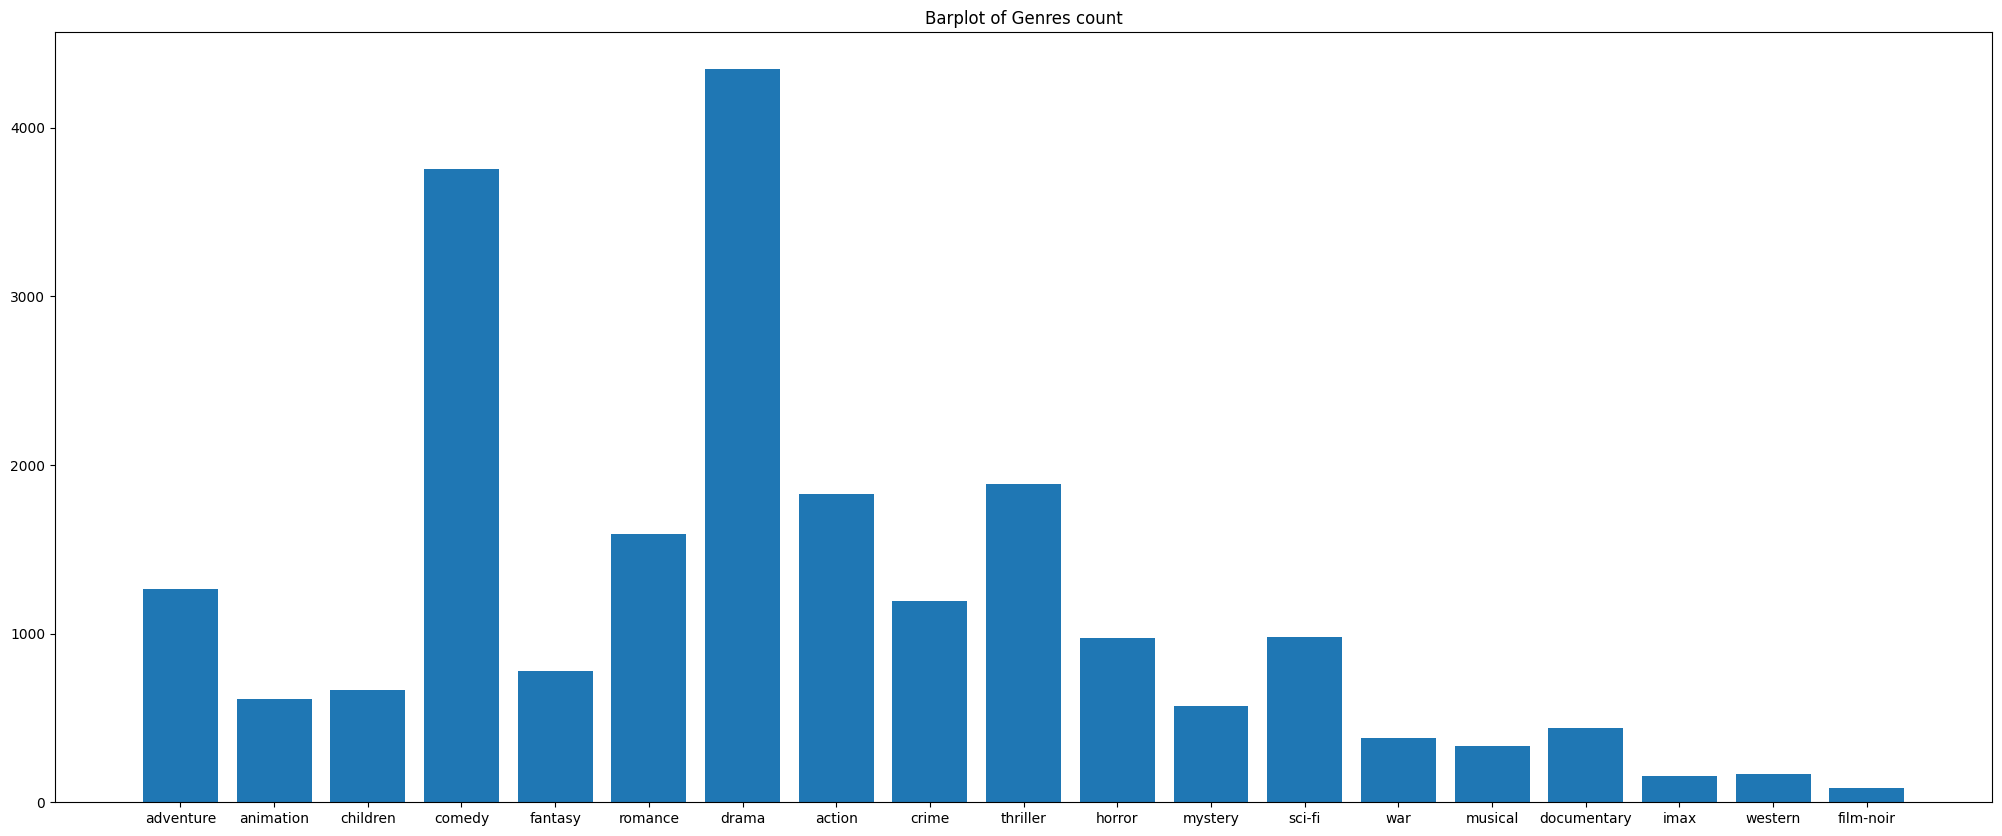

In [45]:
import matplotlib.pyplot as plt
plt.figure(figsize = (25,10))
plt.bar(range(len(movies_genres_dict)), list(movies_genres_dict.values()), tick_label=list(movies_genres_dict.keys()), width = 0.8)
plt.title('Barplot of Genres count')
plt.show()

In [46]:
ratings_list = ratings.select("rating").collect()
ratings_dict = {}
for i in range(len(ratings_list)):
    if ratings_list[i][0] in ratings_dict.keys():
        ratings_dict[ratings_list[i][0]] = ratings_dict[ratings_list[i][0]] + 1
    else:
        ratings_dict[ratings_list[i][0]] = 1

In [47]:
ratings_dict

{4.0: 26818,
 5.0: 13211,
 3.0: 20047,
 2.0: 7551,
 1.0: 2811,
 4.5: 8551,
 3.5: 13136,
 2.5: 5550,
 0.5: 1370,
 1.5: 1791}

<AxesSubplot: xlabel='rating', ylabel='count'>

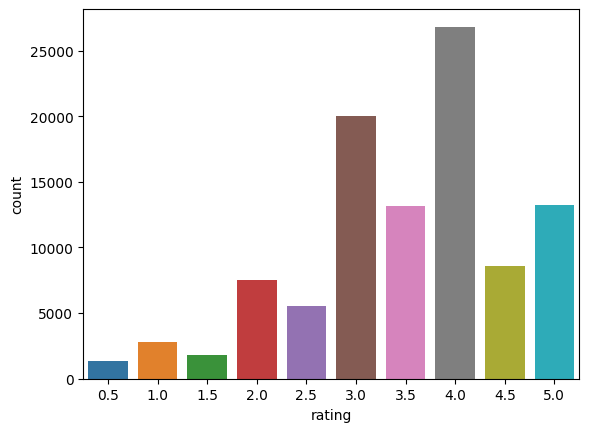

In [48]:
import seaborn as sns
sns.countplot(x='rating', data=ratings.toPandas())

<AxesSubplot: xlabel='rating', ylabel='movieId'>

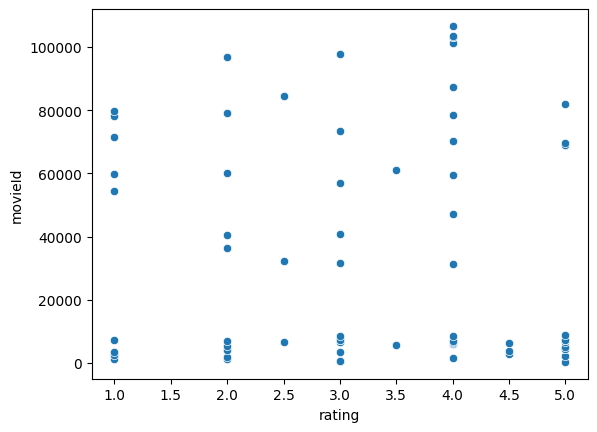

In [49]:
ratings_for_a_movie = ratings.filter(ratings['userId'] == '143')
sns.scatterplot(x = "rating", y = "movieId", data = ratings_for_a_movie.toPandas())

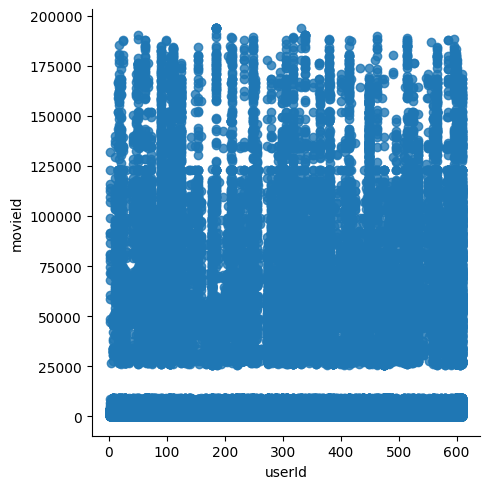

In [50]:
sns.lmplot(x='userId', y='movieId', data=ratings.toPandas(), fit_reg=False);

In [51]:
# Getting id of the movies whose genres in no genres listed
movie_ids_not_rated = movies.filter(movies.genres[0]=="(no genres listed)").select('movieId')

In [52]:
movie_ids_not_rated.show()

+-------+
|movieId|
+-------+
| 114335|
| 122888|
| 122896|
| 129250|
| 132084|
| 134861|
| 141131|
| 141866|
| 142456|
| 143410|
| 147250|
| 149330|
| 152037|
| 155589|
| 156605|
| 159161|
| 159779|
| 161008|
| 165489|
| 166024|
+-------+
only showing top 20 rows



In [53]:
# Removing no genres listed movies from movies dataframe
movies = movies.filter(movies.genres[0]!="(no genres listed)")

In [54]:
# Removing no genres listed movies from ratings dataframe
for i in range(0,len(movie_ids_not_rated.toPandas().values)):
    ratings = ratings.filter(ratings.movieId!=movie_ids_not_rated.toPandas().values[i][0])

In [55]:
# After removing the 34 records with no genres listed
movies.count()

9690

In [56]:
# After removing the 34 records with no genres listed
ratings.count()

100789

In [57]:
movies['genres']

Column<'genres'>

In [58]:
movies_pandas = movies.toPandas()

In [59]:
movies_pandas

,movieId,title,genres
0,1,Toy Story (1995),"[adventure, animation, children, comedy, fantasy]"
1,2,Jumanji (1995),"[adventure, children, fantasy]"
2,3,Grumpier Old Men (1995),"[comedy, romance]"
3,4,Waiting to Exhale (1995),"[comedy, drama, romance]"
4,5,Father of the Bride Part II (1995),[comedy]
...,...,...,...
9685,193581,Black Butler: Book of the Atlantic (2017),"[action, animation, comedy, fantasy]"
9686,193583,No Game No Life: Zero (2017),"[animation, comedy, fantasy]"
9687,193585,Flint (2017),[drama]
9688,193587,Bungo Stray Dogs: Dead Apple (2018),"[action, animation]"


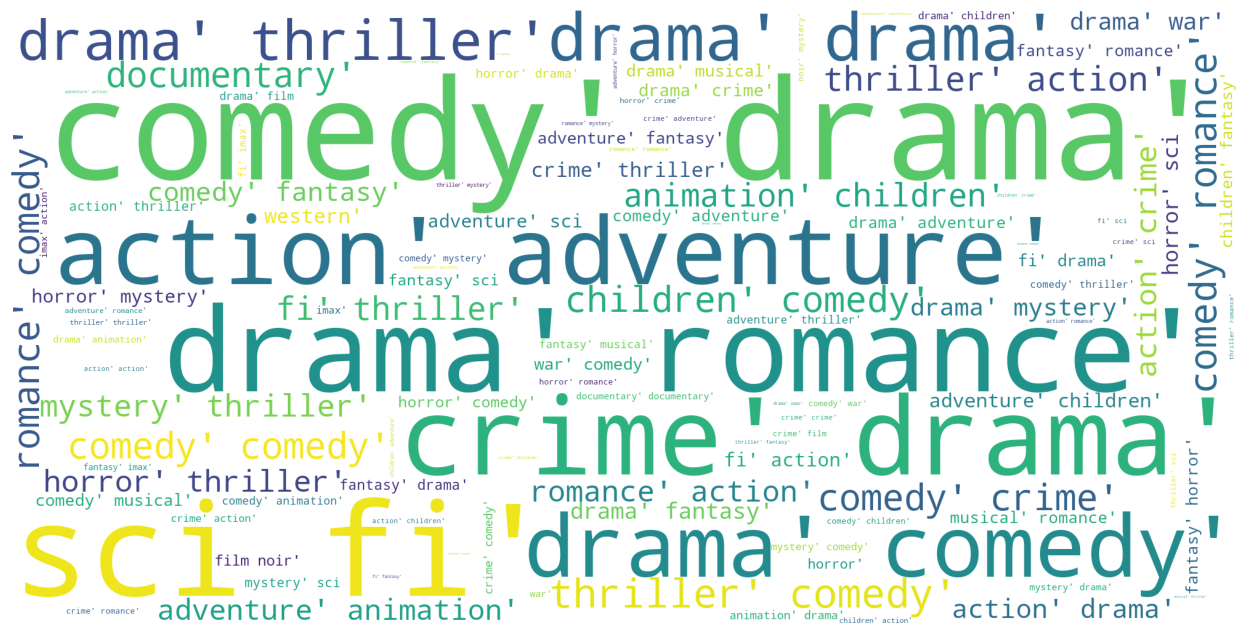

In [60]:
# Plotting the genres of the movies dataset as wordcloud
import wordcloud
from wordcloud import WordCloud, STOPWORDS

movies_pandas['genres'] = movies_pandas['genres'].fillna("").astype('str')
genres = ' '.join(movies_pandas['genres'])
word_cloud_genres = WordCloud(stopwords=STOPWORDS, background_color='white', height=1000, width=2000).generate(genres)

plt.figure(figsize=(16,8))
plt.imshow(word_cloud_genres)
plt.axis('off')
plt.show()

In [61]:
from pyspark.ml.evaluation import RegressionEvaluator

In [62]:
(train,test) = ratings.randomSplit([0.8, 0.2])

In [63]:
(train,validation) = train.randomSplit([0.8, 0.2])

In [64]:
train.count()

64579

In [65]:
validation.count()

16137

In [66]:
test.count()

20073

In [67]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

reg_eval = RegressionEvaluator(predictionCol="Prediction", labelCol="rating", metricName="rmse")

als = ALS()
als.setMaxIter(5)
als.setUserCol("userId")
als.setItemCol("movieId")
als.setRatingCol("rating")
als.setPredictionCol("Prediction")

ranks_arr = [3,4,5,6,7]
errors_arr = [0,0,0,0,0]
models_arr = [0,0,0,0,0]
min_error = float('inf')

index = 0
best_rank = -1

for rank in ranks_arr:
    als.setRank(rank)
    model = als.fit(train)
    predict_df = model.transform(validation)
    # Removing NaN values
    predicted_ratings_df = predict_df.filter(predict_df.Prediction != float('nan'))
    error_val = reg_eval.evaluate(predicted_ratings_df)
    errors_arr[index] = error_val
    models_arr[index] = model
    print('The RMSE value for rank %s is %s' %(rank, error_val))
    if error_val < min_error:
        min_error = error_val
        best_rank = index
    index+= 1

The RMSE value for rank 3 is 0.914316755498781
The RMSE value for rank 4 is 0.9097643620840791
The RMSE value for rank 5 is 0.9145998340867386
The RMSE value for rank 6 is 0.9225160719755402
The RMSE value for rank 7 is 0.9164088658165032


In [68]:
ranks_arr[best_rank]

4

In [69]:
model = models_arr[best_rank]

In [70]:
predicted_results = model.transform(test)

In [71]:
predicted_results.show(5)

+------+-------+------+----------+
|userId|movieId|rating|Prediction|
+------+-------+------+----------+
|     1|      6|   4.0|  4.674481|
|     1|     47|   5.0|  4.624071|
|     1|    110|   4.0|  4.447153|
|     1|    157|   5.0| 3.6412847|
|     1|    163|   5.0|  4.419119|
+------+-------+------+----------+
only showing top 5 rows



In [72]:
predicted_results = predicted_results.filter(predicted_results.Prediction != float('nan'))
test_RMSE_value = reg_eval.evaluate(predicted_results)

In [73]:
from pyspark.sql.types import *
def get_recommendations_using_als(id = None, numItems = 10):
    recommendation = model.recommendForAllUsers(numItems)
    recommended_movies_df = recommendation.where(col("userId")==int(id)).toPandas()
    if len(recommended_movies_df) >0:
        movie_recommended = recommended_movies_df.iloc[0].loc["recommendations"]
        schema = StructType([
              StructField('movieId', IntegerType(), False),
              StructField('Prediction', FloatType(), False)
          ])
        movies_df = spark.createDataFrame(movie_recommended,schema)
        movies_df = movies_df.join(movies,'movieId','left').toPandas()
        user_data = ratings[ratings.userId == (id)].toPandas()
        actual_results= (user_data.merge(movies_df, how = 'left', left_on = 'movieId', right_on = 'movieId').
                     sort_values(['rating'], ascending=False))
    return actual_results,movies_df


In [74]:
# movies_123 = spark.sql('''SELECT userId,count(userId) FROM ratings_table GROUP BY userId ORDER BY count(userId) ASC''')

In [75]:
# movies_123.show(5)

In [76]:
# movies_123 = spark.sql('''SELECT genres FROM movies_table WHERE movieId IN (SELECT movieId FROM ratings_table where userId = '123')''')

In [77]:
# movies_123.show(100, truncate = False)

In [78]:
actual_results, recommendations = get_recommendations_using_als(id = 123)

In [79]:
actual_results

,userId,movieId,rating,Prediction,title,genres
0,123,47,4.5,NaN,NaN,NaN
23,123,58803,4.5,NaN,NaN,NaN
54,123,116797,4.5,NaN,NaN,NaN
52,123,115569,4.5,NaN,NaN,NaN
50,123,112556,4.5,NaN,NaN,NaN
47,123,111759,4.5,NaN,NaN,NaN
46,123,109487,4.5,NaN,NaN,NaN
42,123,99114,4.5,NaN,NaN,NaN
40,123,96829,4.5,NaN,NaN,NaN
35,123,85414,4.5,NaN,NaN,NaN


In [80]:
recommendations

,movieId,Prediction,title,genres
0,96004,5.328371,Dragon Ball Z: The History of Trunks (1993),"[action, adventure, animation]"
1,68945,5.328371,Neon Genesis Evangelion: Death & Rebirth (Shin...,"[action, animation, mystery, sci-fi]"
2,3379,5.328371,On the Beach (1959),[drama]
3,183897,4.931688,Isle of Dogs (2018),"[animation, comedy]"
4,138966,4.895679,Nasu: Summer in Andalusia (2003),[animation]
5,134796,4.895679,Bitter Lake (2015),[documentary]
6,117531,4.895679,Watermark (2014),[documentary]
7,84273,4.895679,Zeitgeist: Moving Forward (2011),[documentary]
8,74226,4.895679,"Dream of Light (a.k.a. Quince Tree Sun, The) (...","[documentary, drama]"
9,26928,4.895679,"Summer's Tale, A (Conte d'été) (1996)","[comedy, drama, romance]"


In [81]:
import numpy as np

actual=actual_results["rating"].iloc[:10]
actual_values=actual.array
predicted_values=recommendations["Prediction"]
predicted_values=predicted_values.array

In [82]:
from sklearn.metrics import mean_squared_error
als_rmse = np.sqrt(mean_squared_error(actual_values,predicted_values))

In [83]:
als_rmse

0.56429774

In [84]:
import tmdbsimple as tmdb
tmdb.API_KEY = 'e3fffa30d4652db4f9dd1be5b4f1666f'

In [85]:
import re 
from IPython.display import Image, HTML, display
html = "<table>"
html += "<tr>"
html += "<h3>Movie Recommendations using Alternating Least Square</h3>"
html += "</tr>"
html += "<tr style='margin-bottom:10px; text-align: center;'>"
html += "<th style= 'text-align: center'>MovieId</th>"
html += "<th style= 'text-align: center'>Title</th>"
html += "<th style= 'text-align: center'>IMDB Link</th>"
html += "<th style= 'text-align: center'>Image</th>"
html += "</tr>"
for index, row in recommendations.iterrows():
    html += "<tr>"
    html += "<td style= 'text-align: center'><h4>%s</h4></td>"%(row['movieId'])
    row['title'] = re.sub("[\(\[].*?[\)\]]", "", row['title'])
    html += "<td style= 'text-align: center'><h4>%s</h4></td>"%(row['title'])
    imdb_id = "tt"+links.filter(links.movieId==row['movieId']).select("imdbId").first()[0]
    html += "<td style= 'text-align: center; width: 200px;'><a href = https://www.imdb.com/title/"+imdb_id+">Click Here </a></td>"
    tmdb_id = links.filter(links.movieId==row['movieId']).select("tmdbId").first()[0]
    try:
        movie_info = tmdb.Movies(tmdb_id).info()
        movie_image_url = 'https://image.tmdb.org/t/p/w500' + movie_info['poster_path']
    except:
        movie_image_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/6/65/No-Image-Placeholder.svg/1200px-No-Image-Placeholder.svg.png'
    html += "<td style='width: 120px'><img src = '"+movie_image_url+"', width = 120 /></td>"
    html += "</tr>"
html += "</table>"
display(HTML(html))

MovieId,Title,IMDB Link,Image
96004,Dragon Ball Z: The History of Trunks,Click Here,
68945,Neon Genesis Evangelion: Death & Rebirth,Click Here,
3379,On the Beach,Click Here,
183897,Isle of Dogs,Click Here,
138966,Nasu: Summer in Andalusia,Click Here,
134796,Bitter Lake,Click Here,
117531,Watermark,Click Here,
84273,Zeitgeist: Moving Forward,Click Here,
74226,Dream of Light,Click Here,
26928,"Summer's Tale, A",Click Here,


In [86]:
actual_results, recommendations = get_recommendations_using_als(id = 437)

In [87]:
recommendations

,movieId,Prediction,title,genres
0,26326,5.663567,"Holy Mountain, The (Montaña sagrada, La) (1973)",[drama]
1,132333,5.507122,Seve (2014),"[documentary, drama]"
2,5490,5.507122,The Big Bus (1976),"[action, comedy]"
3,2843,5.347196,"Black Cat, White Cat (Crna macka, beli macor) ...","[comedy, romance]"
4,96004,5.322002,Dragon Ball Z: The History of Trunks (1993),"[action, adventure, animation]"
5,68945,5.322002,Neon Genesis Evangelion: Death & Rebirth (Shin...,"[action, animation, mystery, sci-fi]"
6,3379,5.322002,On the Beach (1959),[drama]
7,88448,5.259525,Paper Birds (Pájaros de papel) (2010),"[comedy, drama]"
8,177593,5.250784,"Three Billboards Outside Ebbing, Missouri (2017)","[crime, drama]"
9,5915,5.204930,Victory (a.k.a. Escape to Victory) (1981),"[action, drama, war]"


In [88]:
import re 
from IPython.display import Image, HTML, display
html = "<table>"
html += "<tr>"
html += "<h3>Movie Recommendations</h3>"
html += "</tr>"
html += "<tr style='margin-bottom:10px; text-align: center;'>"
html += "<th style= 'text-align: center'>MovieId</th>"
html += "<th style= 'text-align: center'>Title</th>"
html += "<th style= 'text-align: center'>IMDB Link</th>"
html += "<th style= 'text-align: center'>Image</th>"
html += "</tr>"
for index, row in recommendations.iterrows():
    html += "<tr>"
    html += "<td style= 'text-align: center'><h4>%s</h4></td>"%(row['movieId'])
    row['title'] = re.sub("[\(\[].*?[\)\]]", "", row['title'])
    html += "<td style= 'text-align: center'><h4>%s</h4></td>"%(row['title'])
    imdb_id = "tt"+links.filter(links.movieId==row['movieId']).select("imdbId").first()[0]
    html += "<td style= 'text-align: center; width: 200px;'><a href = https://www.imdb.com/title/"+imdb_id+">Click Here </a></td>"
    tmdb_id = links.filter(links.movieId==row['movieId']).select("tmdbId").first()[0]
    try:
        movie_info = tmdb.Movies(tmdb_id).info()
        movie_image_url = 'https://image.tmdb.org/t/p/w500' + movie_info['poster_path']
    except:
        movie_image_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/6/65/No-Image-Placeholder.svg/1200px-No-Image-Placeholder.svg.png'
    html += "<td style='width: 120px'><img src = '"+movie_image_url+"', width = 120 /></td>"
    html += "</tr>"
html += "</table>"
display(HTML(html))

MovieId,Title,IMDB Link,Image
26326,"Holy Mountain, The",Click Here,
132333,Seve,Click Here,
5490,The Big Bus,Click Here,
2843,"Black Cat, White Cat",Click Here,
96004,Dragon Ball Z: The History of Trunks,Click Here,
68945,Neon Genesis Evangelion: Death & Rebirth,Click Here,
3379,On the Beach,Click Here,
88448,Paper Birds,Click Here,
177593,"Three Billboards Outside Ebbing, Missouri",Click Here,
5915,Victory,Click Here,


### Singular Value Decomposition

In [89]:
import numpy as np
import pandas as pd
movies=pd.read_csv("movies.csv")
ratings=pd.read_csv("ratings.csv")
# Merging ratings and movies with outerjoin on movieId
movies_ratings=pd.merge(ratings,movies,how='outer',on='movieId')

In [90]:
movies_ratings

,userId,movieId,rating,timestamp,title,genres
0,1.0,1,4.0,9.649827e+08,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5.0,1,4.0,8.474350e+08,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7.0,1,4.5,1.106636e+09,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15.0,1,2.5,1.510578e+09,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17.0,1,4.5,1.305696e+09,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
...,...,...,...,...,...,...
100849,NaN,30892,NaN,NaN,In the Realms of the Unreal (2004),Animation|Documentary
100850,NaN,32160,NaN,NaN,Twentieth Century (1934),Comedy
100851,NaN,32371,NaN,NaN,Call Northside 777 (1948),Crime|Drama|Film-Noir
100852,NaN,34482,NaN,NaN,"Browning Version, The (1951)",Drama


In [91]:
#Create a cross_Table for with user_id,movie_id having values of ratings
Cross_Table=ratings.pivot(index = 'userId', columns ='movieId', values = 'rating').fillna(0)

In [92]:
Cross_Table

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608,2.5,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [93]:
#Convert it to matrix
Cross_Table_matrix=np.asmatrix(Cross_Table)

In [94]:
Cross_Table_matrix

matrix([[4. , 0. , 4. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        ...,
        [2.5, 2. , 2. , ..., 0. , 0. , 0. ],
        [3. , 0. , 0. , ..., 0. , 0. , 0. ],
        [5. , 0. , 0. , ..., 0. , 0. , 0. ]])

In [95]:
#Take the mean of all ratings for each user by taking mean of cross table alomg the coloumn
user_mean_ratings=np.mean(Cross_Table_matrix,axis=1)

In [96]:
user_mean_ratings

matrix([[0.10417524],
        [0.01177499],
        [0.00976964],
        [0.07897984],
        [0.01645413],
        [0.11281366],
        [0.05049362],
        [0.01727684],
        [0.01542575],
        [0.0472028 ],
        [0.02488688],
        [0.01444879],
        [0.01162073],
        [0.01676265],
        [0.04787125],
        [0.03753599],
        [0.04545455],
        [0.19266763],
        [0.18850267],
        [0.08936652],
        [0.14854998],
        [0.03146853],
        [0.04540313],
        [0.04128959],
        [0.01285479],
        [0.00699301],
        [0.04925956],
        [0.1770362 ],
        [0.03450226],
        [0.01655697],
        [0.02015631],
        [0.03938708],
        [0.06077746],
        [0.03023447],
        [0.0096668 ],
        [0.01624846],
        [0.00894694],
        [0.02581242],
        [0.04113534],
        [0.03990128],
        [0.07260387],
        [0.16135335],
        [0.0533731 ],
        [0.01655697],
        [0.15903949],
        [0

In [97]:
#Demean or normalise the data
Demeaned_Data=Cross_Table_matrix-user_mean_ratings

In [98]:
Demeaned_Data

matrix([[ 3.89582476, -0.10417524,  3.89582476, ..., -0.10417524,
         -0.10417524, -0.10417524],
        [-0.01177499, -0.01177499, -0.01177499, ..., -0.01177499,
         -0.01177499, -0.01177499],
        [-0.00976964, -0.00976964, -0.00976964, ..., -0.00976964,
         -0.00976964, -0.00976964],
        ...,
        [ 2.23215755,  1.73215755,  1.73215755, ..., -0.26784245,
         -0.26784245, -0.26784245],
        [ 2.98755656, -0.01244344, -0.01244344, ..., -0.01244344,
         -0.01244344, -0.01244344],
        [ 4.50611888, -0.49388112, -0.49388112, ..., -0.49388112,
         -0.49388112, -0.49388112]])

In [99]:
#Matrix Fcatorisation using singular value decomposition
from scipy.sparse.linalg import svds
U, sigma, Vt = svds(Demeaned_Data, k = 50)

In [100]:
U

array([[ 0.01716626, -0.00032694, -0.01194615, ...,  0.00335838,
        -0.06213084, -0.0596384 ],
       [ 0.00501697,  0.0010387 , -0.01505205, ..., -0.0012344 ,
         0.01767432, -0.00626322],
       [-0.00065179, -0.00538272,  0.00649223, ...,  0.00067537,
        -0.00203417, -0.00064958],
       ...,
       [ 0.16117225, -0.13376441,  0.05557292, ..., -0.01464468,
        -0.01227985, -0.11854893],
       [-0.0089301 ,  0.00652333,  0.00537419, ..., -0.04097903,
        -0.01400112, -0.00856716],
       [-0.01039005,  0.00880112, -0.06333814, ...,  0.06183579,
         0.20316391, -0.12143586]])

In [101]:
sigma

array([ 67.86628347,  68.1967072 ,  69.02678246,  69.4170401 ,
        69.91863747,  70.02091789,  70.19408599,  71.67445157,
        72.43371861,  73.21879553,  73.43760593,  74.02644882,
        74.28978377,  74.9207733 ,  75.17528213,  75.59325141,
        76.70227225,  77.35717925,  78.39405157,  79.04344482,
        79.21217131,  80.56747647,  81.5467832 ,  82.1973482 ,
        83.04447645,  85.11688914,  85.74871886,  86.51711471,
        87.91550637,  90.33575237,  90.9340682 ,  92.26271695,
        93.39976829,  97.10067118,  99.28906754,  99.82361796,
       101.84794614, 105.97367358, 107.04782929, 109.20838712,
       112.80840902, 120.61532345, 122.64724436, 134.58721632,
       139.637245  , 153.93097112, 163.73084057, 184.86187801,
       231.22453421, 474.20606204])

In [102]:
#Sigma returned should be converted to daigonal matrix
sigma=np.diag(sigma)

In [103]:
sigma

array([[ 67.86628347,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,  68.1967072 ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,  69.02678246, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.        ,   0.        ,   0.        , ..., 184.86187801,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
        231.22453421,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        , 474.20606204]])

In [104]:
Vt

array([[-5.06053498e-02,  1.46261894e-03,  2.28232417e-03, ...,
        -1.42764417e-03, -1.42764417e-03,  2.96452853e-03],
       [ 2.95078801e-02, -2.17971445e-02,  2.25072247e-02, ...,
         2.92507189e-03,  2.92507189e-03, -9.95934144e-05],
       [ 6.65561487e-02,  1.43370497e-02, -2.64013814e-02, ...,
         4.79377861e-04,  4.79377861e-04,  1.49239941e-03],
       ...,
       [-6.77263279e-02, -6.97142996e-02, -2.91611099e-02, ...,
        -2.24798857e-03, -2.24798857e-03, -2.06691001e-03],
       [-2.84008740e-02, -2.36032577e-03, -2.47048049e-02, ...,
         7.01753154e-04,  7.01753154e-04,  1.36888991e-03],
       [-7.60983302e-02, -3.84874039e-02, -1.24439904e-02, ...,
         5.10178162e-03,  5.10178162e-03,  4.81883687e-03]])

In [105]:
# Predict the movie rating for every user
predicted_ratings=np.dot(np.dot(U, sigma), Vt) + user_mean_ratings.reshape(-1, 1)

In [106]:
predicted_ratings

matrix([[ 2.16732840e+00,  4.02750508e-01,  8.40183552e-01, ...,
         -2.34533753e-02, -2.34533753e-02, -5.87318552e-02],
        [ 2.11459069e-01,  6.65755884e-03,  3.34547997e-02, ...,
          1.94980595e-02,  1.94980595e-02,  3.22813825e-02],
        [ 3.58844848e-03,  3.05175179e-02,  4.63929239e-02, ...,
          5.90929301e-03,  5.90929301e-03,  8.00411072e-03],
        ...,
        [ 2.16136388e+00,  2.67091989e+00,  2.12845971e+00, ...,
         -4.40029476e-02, -4.40029476e-02,  7.18717825e-02],
        [ 7.80205947e-01,  5.33648654e-01,  9.64537701e-02, ...,
          4.35514249e-03,  4.35514249e-03, -1.34622131e-03],
        [ 5.36398127e+00, -3.40945139e-01, -1.75163291e-01, ...,
         -2.63577616e-02, -2.63577616e-02,  5.15415792e-02]])

In [107]:
Predicted_Matrix= pd.DataFrame(data=predicted_ratings,columns=Cross_Table.columns)

In [108]:
Predicted_Matrix

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
0,2.167328,0.402751,0.840184,-0.076281,-0.551337,2.504091,-0.890114,-0.026443,0.196974,1.593259,...,-0.023453,-0.019967,-0.026939,-0.026939,-0.023453,-0.026939,-0.023453,-0.023453,-0.023453,-0.058732
1,0.211459,0.006658,0.033455,0.017419,0.183430,-0.062473,0.083037,0.024158,0.049330,-0.152530,...,0.019498,0.016777,0.022219,0.022219,0.019498,0.022219,0.019498,0.019498,0.019498,0.032281
2,0.003588,0.030518,0.046393,0.008176,-0.006247,0.107328,-0.012416,0.003779,0.007297,-0.059362,...,0.005909,0.006209,0.005610,0.005610,0.005909,0.005610,0.005909,0.005909,0.005909,0.008004
3,2.051549,-0.387104,-0.252199,0.087562,0.130465,0.270210,0.477835,0.040313,0.025858,-0.017365,...,0.004836,0.004172,0.005500,0.005500,0.004836,0.005500,0.004836,0.004836,0.004836,-0.023311
4,1.344738,0.778511,0.065749,0.111744,0.273144,0.584426,0.254930,0.128788,-0.085541,1.023455,...,-0.008042,-0.007419,-0.008664,-0.008664,-0.008042,-0.008664,-0.008042,-0.008042,-0.008042,-0.010127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,2.501444,-0.139015,-0.082080,0.079300,-0.158770,-0.587275,2.368039,-0.014790,-0.093695,-0.182211,...,-0.038935,-0.032500,-0.045369,-0.045369,-0.038935,-0.045369,-0.038935,-0.038935,-0.038935,-0.045416
606,2.849138,1.368651,0.341869,0.000534,-0.272603,1.529573,-0.078889,-0.013913,0.075251,1.398731,...,0.006789,0.006108,0.007471,0.007471,0.006789,0.007471,0.006789,0.006789,0.006789,-0.030371
607,2.161364,2.670920,2.128460,0.036007,0.128314,3.684387,-0.028717,0.195936,0.073591,2.406330,...,-0.044003,-0.041123,-0.046882,-0.046882,-0.044003,-0.046882,-0.044003,-0.044003,-0.044003,0.071872
608,0.780206,0.533649,0.096454,0.029945,0.087756,0.209604,0.078704,0.061626,-0.064337,1.242835,...,0.004355,0.004268,0.004442,0.004442,0.004355,0.004442,0.004355,0.004355,0.004355,-0.001346


In [109]:
def get_recommendations_using_svd(preds_df, userID, movies_df, original_ratings_df, num_of_recomd=5):
    user_row_number = userID - 1
    sorted_user_predictions = preds_df.iloc[user_row_number].sort_values(ascending=False)
    user_data = original_ratings_df[original_ratings_df.userId == (userID)]
    actual_results= (user_data.merge(movies_df, how = 'left', left_on = 'movieId', right_on = 'movieId').
                     sort_values(['rating'], ascending=False))
    recommendations = (movies_df[movies_df['movieId'].isin(actual_results['movieId'])].
            merge(pd.DataFrame(sorted_user_predictions).reset_index(), how="outer").
        sort_values(user_row_number,ascending=False).
                      iloc[:num_of_recomd, :])
    recommendations=recommendations.rename(columns={user_row_number:"Predictions"})
    return actual_results, recommendations

In [110]:
actual, svd_recommendations = get_recommendations_using_svd(Predicted_Matrix, 137,movies ,ratings, 10)
svd_recommendations

,movieId,title,genres,Predictions
22,858,"Godfather, The (1972)",Crime|Drama,5.203183
8,318,"Shawshank Redemption, The (1994)",Crime|Drama,5.160536
5,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,4.901584
46,1198,Raiders of the Lost Ark (Indiana Jones and the...,Action|Adventure,4.744528
16,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,4.684773
19,750,Dr. Strangelove or: How I Learned to Stop Worr...,Comedy|War,4.532452
11,527,Schindler's List (1993),Drama|War,4.505791
44,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi,4.306458
27,912,Casablanca (1942),Drama|Romance,4.266428
124,5952,"Lord of the Rings: The Two Towers, The (2002)",Adventure|Fantasy,3.966969


In [111]:
actual

,userId,movieId,rating,timestamp,title,genres
34,137,951,5.0,1204859789,His Girl Friday (1940),Comedy|Romance
55,137,1221,5.0,1204859699,"Godfather: Part II, The (1974)",Crime|Drama
31,137,923,5.0,1204859839,Citizen Kane (1941),Drama|Mystery
30,137,922,5.0,1204859734,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),Drama|Film-Noir|Romance
29,137,919,5.0,1204859924,"Wizard of Oz, The (1939)",Adventure|Children|Fantasy|Musical
...,...,...,...,...,...,...
103,137,3421,3.0,1204859946,Animal House (1978),Comedy
105,137,3471,3.0,1204859953,Close Encounters of the Third Kind (1977),Adventure|Drama|Sci-Fi
118,137,4963,2.5,1204859503,Ocean's Eleven (2001),Crime|Thriller
101,137,3072,2.0,1204859010,Moonstruck (1987),Comedy|Romance


In [112]:
import re 
from IPython.display import Image, HTML, display
html = "<table>"
html += "<tr>"
html += "<h3>Movie Recommendations using Singular Value Decomposition</h3>"
html += "</tr>"
html += "<tr style='margin-bottom:10px; text-align: center;'>"
html += "<th style= 'text-align: center'>MovieId</th>"
html += "<th style= 'text-align: center'>Title</th>"
html += "<th style= 'text-align: center'>IMDB Link</th>"
html += "<th style= 'text-align: center'>Image</th>"
html += "</tr>"
for index, row in svd_recommendations.iterrows():
    html += "<tr>"
    html += "<td style= 'text-align: center'><h4>%s</h4></td>"%(row['movieId'])
#     row['title'] = re.sub("[\(\[].*?[\)\]]", "", row['title'])
    html += "<td style= 'text-align: center'><h4>%s</h4></td>"%(row['title'])
    imdb_id = "tt"+links.filter(links.movieId==row['movieId']).select("imdbId").first()[0]
    html += "<td style= 'text-align: center; width: 200px;'><a href = https://www.imdb.com/title/"+imdb_id+">Click Here </a></td>"
    tmdb_id = links.filter(links.movieId==row['movieId']).select("tmdbId").first()[0]
    try:
        movie_info = tmdb.Movies(tmdb_id).info()
        movie_image_url = 'https://image.tmdb.org/t/p/w500' + movie_info['poster_path']
    except:
        movie_image_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/6/65/No-Image-Placeholder.svg/1200px-No-Image-Placeholder.svg.png'
    html += "<td style='width: 120px'><img src = '"+movie_image_url+"', width = 120 /></td>"
    html += "</tr>"
html += "</table>"
display(HTML(html))

MovieId,Title,IMDB Link,Image
858,"Godfather, The (1972)",Click Here,
318,"Shawshank Redemption, The (1994)",Click Here,
260,Star Wars: Episode IV - A New Hope (1977),Click Here,
1198,Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),Click Here,
593,"Silence of the Lambs, The (1991)",Click Here,
750,Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964),Click Here,
527,Schindler's List (1993),Click Here,
1196,Star Wars: Episode V - The Empire Strikes Back (1980),Click Here,
912,Casablanca (1942),Click Here,
5952,"Lord of the Rings: The Two Towers, The (2002)",Click Here,


In [113]:
actual=actual["rating"].iloc[:10]
actual_values=actual.array
predicted=svd_recommendations["Predictions"]
predicted_values=predicted.array

In [114]:
from sklearn.metrics import mean_squared_error

In [115]:
svd_rmse = np.sqrt(mean_squared_error(actual_values,predicted_values))

In [116]:
svd_rmse

0.5282518562934312

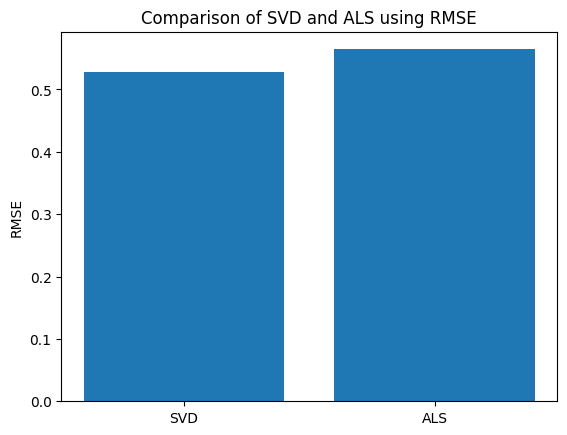

In [117]:
plt.bar(['SVD', 'ALS'], [svd_rmse, als_rmse])
plt.title('Comparison of SVD and ALS using RMSE')
plt.ylabel('RMSE')
plt.show()

From the graph, we can infer that the RMSE value of SVD is low when compared to ALS, which gives a conclusion that the SVD performs better compared to ALS.